In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## **Task 1**

In [3]:
# import data
data1_df = pd.read_csv('/content/data_task1.txt', sep='\t')
data1_df

,login,tid,Microtasks,assigned_ts,closed_ts
0,login0,190563850.0,4.0,2017-04-20 12:09:39,2017-04-20 13:13:01
1,login0,190561754.0,1.0,2017-04-20 12:10:30,2017-04-20 12:28:29
2,login0,190565906.0,4.0,2017-04-20 12:21:31,2017-04-20 13:30:10
3,login0,190560246.0,1.0,2017-04-20 12:28:30,2017-04-20 13:13:56
4,login0,190562168.0,2.0,2017-04-20 12:28:42,2017-04-20 13:14:50
...,...,...,...,...,...
453157,login499,167770512.0,6.0,2017-05-13 19:52:13,2017-05-13 19:55:03
453158,login499,167772734.0,1.0,2017-05-13 19:52:47,2017-05-13 19:55:11
453159,login499,167770870.0,11.0,2017-05-13 19:55:04,2017-05-13 20:04:15
453160,login499,167769824.0,7.0,2017-05-13 19:55:12,2017-05-13 20:09:17


In [4]:
# show data set description, identify missing values
data1_df.info()
data1_df['assigned_ts'] = pd.to_datetime(data1_df['assigned_ts'])
data1_df['closed_ts'] = pd.to_datetime(data1_df['closed_ts'])
data1_df[data1_df.isnull().any(axis=1)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453162 entries, 0 to 453161
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   login        453162 non-null  object 
 1   tid          453162 non-null  float64
 2   Microtasks   453162 non-null  float64
 3   assigned_ts  453162 non-null  object 
 4   closed_ts    453161 non-null  object 
dtypes: float64(2), object(3)
memory usage: 17.3+ MB


,login,tid,Microtasks,assigned_ts,closed_ts
453161,login499,195364212.0,13.0,2017-05-01,NaT


In [5]:
# drop rows with missing data
data1_cleaned_df = data1_df.dropna()

In [6]:
# check for errors in data
idx = data1_cleaned_df.query('assigned_ts > closed_ts').index
data1_cleaned_df = data1_cleaned_df[~data1_cleaned_df.index.isin(idx)]

In [7]:
# Generating new features

# группируем данные по асессеру и дню работы, получаем для КАЖДОГО ДНЯ:
# count_tasks	- число выполненных задач
# count_microtasks	- число выполненных микрозадач
# start_time_day	- предполагаемое время начала работы
# end_time_day	- фактическое время окончания работы
# time_spent_on_daily_tasks - разница между концом и началом работы

assessors_tasks_df = (data1_cleaned_df.groupby(['login', data1_cleaned_df['assigned_ts'].dt.date])['tid', 'Microtasks', 'assigned_ts',	'closed_ts']
                      .agg({'tid': 'count', 'Microtasks': 'sum', 'assigned_ts': 'min', 'closed_ts': 'max'})
)
assessors_tasks_df = assessors_tasks_df.rename(columns={'tid': 'count_tasks', 'Microtasks': 'count_microtasks', 'assigned_ts': 'start_time_day', 'closed_ts': 'end_time_day'})
assessors_tasks_df['time_spent_on_daily_tasks'] =  assessors_tasks_df['end_time_day'] - assessors_tasks_df['start_time_day']
assessors_tasks_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # Remove the CWD from sys.path while we load stuff.


count_tasks  ...  time_spent_on_daily_tasks
login   assigned_ts               ...                           
login0  2017-04-20            15  ...            0 days 07:26:02
        2017-04-21           176  ...            0 days 07:46:03
        2017-04-23             1  ...            0 days 16:13:08
        2017-04-24             8  ...            0 days 06:41:32
        2017-04-25            41  ...            0 days 05:55:45
...                          ...  ...                        ...
login99 2017-05-20            15  ...            0 days 16:23:40
        2017-05-21            11  ...            0 days 04:32:31
        2017-05-24            19  ...            0 days 00:27:58
        2017-05-25             5  ...            0 days 00:04:39
        2017-05-28             4  ...            0 days 11:43:41

[9801 rows x 5 columns]

In [14]:
# Generating new features

# группируем данные по асессеру, получаем для КАЖДОГО АСЕССОРА:
# count_tasks	- число выполненных задач
# count_microtasks	- число выполненных микрозадач
# avg_time_on_microtask	- среднее время выполнения одной микрозадачи за всё время
# avg_time_on_microtask_sec	- среднее время выполнения одной микрозадачи за всё время (в секундах)
# avg_speed_microtasks_per_sec	- средняя скорость работы (число микрозадач в сек) 


assessors_tasks_df = assessors_tasks_df.groupby('login')[['count_tasks', 'count_microtasks', 'time_spent_on_daily_tasks']].sum(numeric_only=False)

assessors_tasks_df['avg_time_on_microtask'] = assessors_tasks_df['time_spent_on_daily_tasks'] / assessors_tasks_df['count_microtasks']

assessors_tasks_df['avg_time_on_microtask_sec'] = assessors_tasks_df['avg_time_on_microtask'].dt.total_seconds().astype(int)
assessors_tasks_df['avg_speed_microtasks_per_sec'] = 1 / assessors_tasks_df['avg_time_on_microtask_sec']

assessors_tasks_df = assessors_tasks_df.sort_values('avg_speed_microtasks_per_sec', ascending=False)
assessors_tasks_df

,count_tasks,count_microtasks,time_spent_on_daily_tasks,avg_time_on_microtask,avg_time_on_microtask_sec,avg_speed_microtasks_per_sec
login,,,,,,
login282,1,1.0,0 days 00:00:25,0 days 00:00:25,25,0.040000
login40,139,415.0,0 days 03:12:35,0 days 00:00:27.843373493,27,0.037037
login96,43,107.0,0 days 00:51:14,0 days 00:00:28.728971962,28,0.035714
login254,2700,7562.0,2 days 16:24:48,0 days 00:00:30.664903464,30,0.033333
login147,71,110.0,0 days 00:55:25,0 days 00:00:30.227272727,30,0.033333
...,...,...,...,...,...,...
login176,24,72.0,6 days 09:15:40,0 days 02:07:43.055555555,7663,0.000130
login303,4,10.0,0 days 22:47:07,0 days 02:16:42.700000,8202,0.000122
login380,22,50.0,5 days 05:32:58,0 days 02:30:39.560000,9039,0.000111


In [15]:
# descriptive statistics
assessors_tasks_df.describe()

,count_tasks,count_microtasks,time_spent_on_daily_tasks,avg_time_on_microtask,avg_time_on_microtask_sec,avg_speed_microtasks_per_sec
count,500.000000,500.000000,500,500,500.000000,500.000000
mean,906.322000,2972.204000,8 days 17:45:42.142000,0 days 00:12:03.969735015,723.480000,0.005275
std,1503.691848,4897.875623,9 days 17:36:33.102258432,0 days 00:28:36.533741106,1716.552455,0.006285
min,1.000000,1.000000,0 days 00:00:25,0 days 00:00:25,25.000000,0.000035
25%,127.750000,362.750000,2 days 04:20:10.500000,0 days 00:02:42.180134089,161.750000,0.001706
50%,465.000000,1522.500000,6 days 04:40:56,0 days 00:05:25.638984360,325.000000,0.003077
75%,1034.250000,3506.250000,12 days 00:49:07.250000,0 days 00:09:46.254716274,586.000000,0.006182
max,13721.000000,51402.000000,114 days 23:55:19,0 days 07:51:03,28263.000000,0.040000


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


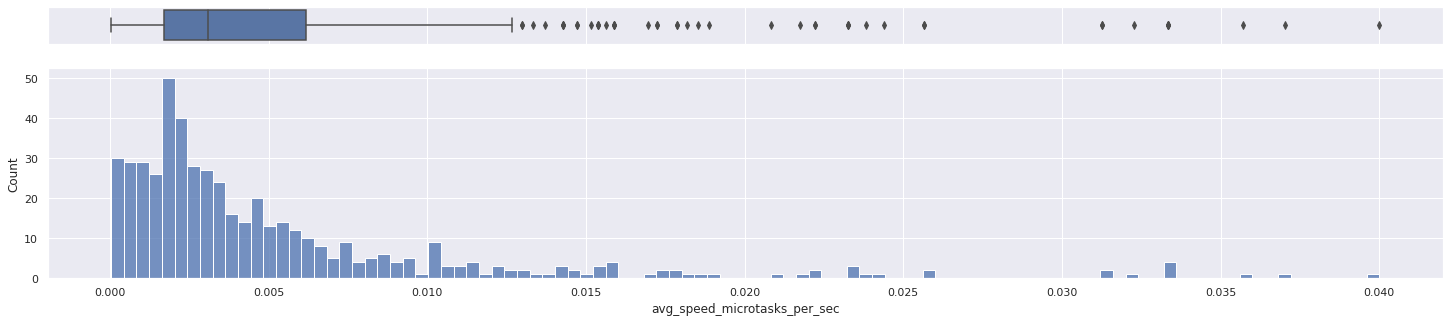

In [19]:
# Визуализируем распределение данных в avg_speed_microtasks_per_sec

sns.set(style="darkgrid")
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(25, 5))

sns.boxplot(assessors_tasks_df["avg_speed_microtasks_per_sec"], ax=ax_box)
sns.histplot(data=assessors_tasks_df, x="avg_speed_microtasks_per_sec", ax=ax_hist, bins=100)
 
ax_box.set(xlabel='')
plt.show()

In [11]:
# Определение функции для расчёта бонуса для справедливой оплаты труда

max_bonus_pct = 50  # % от зп за 1 микрозадание, условная константа


def get_value_ratio_in_range(val: float, min_val: float, max_val: float) -> float:
  return (val - min_val) / (max_val - min_val)


def get_personal_bonus_pct(personal_speed: int, common_speed_ser: pd.Series) -> int:

  qntl_0 = common_speed_ser.min()
  qntl_25 = common_speed_ser.quantile(0.25)
  qntl_50 = common_speed_ser.quantile(0.50)
  qntl_75 = common_speed_ser.quantile(0.75)
  qntl_100 = common_speed_ser.max()

  if personal_speed < qntl_25:
    bonus = max_bonus_pct * 0.25
    bonus *= get_value_ratio_in_range(personal_speed, qntl_0, qntl_25)
    return bonus
  elif personal_speed < qntl_50:
    bonus = max_bonus_pct * 0.5
    bonus *= get_value_ratio_in_range(personal_speed, qntl_25, qntl_50)
    return bonus
  elif personal_speed < qntl_75:
    bonus = max_bonus_pct * 0.75
    bonus *= get_value_ratio_in_range(personal_speed, qntl_50, qntl_75)
    return bonus
  else:  
    bonus = max_bonus_pct * 1.0
    bonus *= get_value_ratio_in_range(personal_speed, qntl_75, qntl_100)
    return bonus

In [17]:
# Какую оплату вы считаете справедливой для выполнения асессором одного микрозадания из этого файла? 
# Решение - assessors_tasks_df['avg_bonus_per_microtask']

base_salary = 100  # руб безусловного дохода за 1 микрозадание, константа

common_speed_ser = assessors_tasks_df['avg_speed_microtasks_per_sec']
assessors_tasks_df['avg_bonus_per_microtask'] = base_salary * common_speed_ser.apply(lambda speed: get_personal_bonus_pct(speed, common_speed_ser)) /100

assessors_tasks_df

,count_tasks,count_microtasks,time_spent_on_daily_tasks,avg_time_on_microtask,avg_time_on_microtask_sec,avg_speed_microtasks_per_sec,avg_bonus_per_microtask
login,,,,,,,
login282,1,1.0,0 days 00:00:25,0 days 00:00:25,25,0.040000,50.000000
login40,139,415.0,0 days 03:12:35,0 days 00:00:27.843373493,27,0.037037,45.619197
login96,43,107.0,0 days 00:51:14,0 days 00:00:28.728971962,28,0.035714,43.663481
login254,2700,7562.0,2 days 16:24:48,0 days 00:00:30.664903464,30,0.033333,40.143192
login147,71,110.0,0 days 00:55:25,0 days 00:00:30.227272727,30,0.033333,40.143192
...,...,...,...,...,...,...,...
login176,24,72.0,6 days 09:15:40,0 days 02:07:43.055555555,7663,0.000130,0.711471
login303,4,10.0,0 days 22:47:07,0 days 02:16:42.700000,8202,0.000122,0.647324
login380,22,50.0,5 days 05:32:58,0 days 02:30:39.560000,9039,0.000111,0.562875


## **Task 2**

In [ ]:
data2_df = pd.read_csv('/content/data_task2.csv', sep='\t')
data2_df

,login,uid,docid,jud,cjud
0,assessor158,158,0,0,0
1,assessor238,238,0,0,0
2,assessor488,488,0,0,0
3,assessor136,136,0,0,0
4,assessor300,300,0,0,0
...,...,...,...,...,...
249995,assessor208,208,49999,1,1
249996,assessor139,139,49999,1,1
249997,assessor333,333,49999,1,1
249998,assessor160,160,49999,1,1


In [ ]:
data2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   login   250000 non-null  object
 1   uid     250000 non-null  int64 
 2   docid   250000 non-null  int64 
 3   jud     250000 non-null  int64 
 4   cjud    250000 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 9.5+ MB


In [ ]:
# Generating new features

# Определяем правильный либо ошибочный ответ дал каждый асессор
data2_df['match'] = np.where(data2_df["cjud"] == data2_df["jud"], 1, 0)
assessors_df = data2_df.copy()
assessors_df

,login,uid,docid,jud,cjud,match
0,assessor158,158,0,0,0,1
1,assessor238,238,0,0,0,1
2,assessor488,488,0,0,0,1
3,assessor136,136,0,0,0,1
4,assessor300,300,0,0,0,1
...,...,...,...,...,...,...
249995,assessor208,208,49999,1,1,1
249996,assessor139,139,49999,1,1,1
249997,assessor333,333,49999,1,1,1
249998,assessor160,160,49999,1,1,1


In [ ]:
# Generating new features

# Считаем количество правильных и неправильных ответов для каждого асессора
matches_df = assessors_df.groupby(['uid', 'match']).size().reset_index().rename(columns={0: 'count_matches'})
matches_df

,uid,match,count_matches
0,0,0,65
1,0,1,336
2,1,0,82
3,1,1,330
4,2,0,76
...,...,...,...
1195,597,1,383
1196,598,0,94
1197,598,1,324
1198,599,0,40


In [ ]:
# Generating new features

# Считаем долю правильных и неправильных ответов от общего числа для каждого асессора
matches_df['pct_from_tll'] = (matches_df.groupby(['uid', 'match'])
                                        .agg({"count_matches" : "sum"})
                                        .groupby(level=0)
                                        .apply(lambda x: round(x/x.sum() * 100, 2))
                                        .rename(columns={'count_matches': 'pct_from_tll'})
                                        .reset_index()['pct_from_tll']
)
matches_df

,uid,match,count_matches,pct_from_tll
0,0,0,65,16.21
1,0,1,336,83.79
2,1,0,82,19.90
3,1,1,330,80.10
4,2,0,76,20.05
...,...,...,...,...
1195,597,1,383,89.28
1196,598,0,94,22.49
1197,598,1,324,77.51
1198,599,0,40,9.43


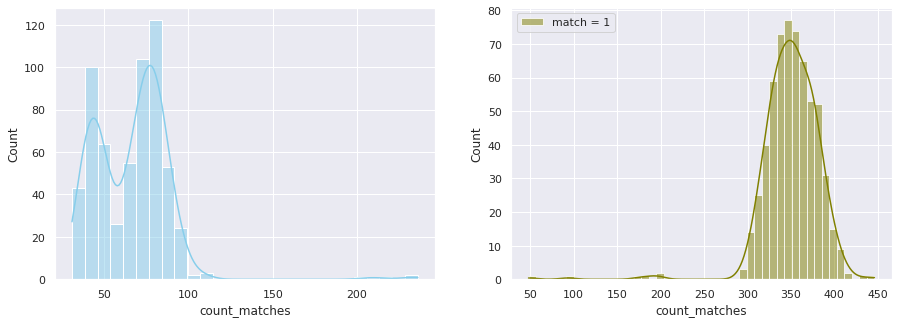

In [ ]:
# Визуализируем распределение данных в count_matches для правильных и ошибочных ответов

sns.set(style="darkgrid")

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=matches_df[matches_df['match'] == 0], x="count_matches", kde=True, label="match = 0", color="skyblue", ax=axs[0])
sns.histplot(data=matches_df[matches_df['match'] == 1], x="count_matches", kde=True, label="match = 1", color="olive", ax=axs[1])

plt.legend() 
plt.show()

In [ ]:
# Используя данные об оценках, установите, какие асессоры хуже всего справились с заданием.

# Асессоры, которые хуже всего справились с заданием, совершили более 50 % ошибок при оценивании документов
matches_df[(matches_df['match'] == 0) & (matches_df['pct_from_tll'] > 50)].sort_values('pct_from_tll', ascending=False)

,uid,match,count_matches,pct_from_tll
112,56,0,236,57.42
6,3,0,230,53.99
236,118,0,205,52.43
780,390,0,214,51.94
468,234,0,51,51.52
